# Exploratory data analysis for charm tagging using charged and excited D meson decays

Quantum Chromodynamics (QCD) is the quantum field theory of the strong nuclear force. It is based upon an SU(3) gauge symmetry, and couples together particles which carry the color charge quantum number.

Amongst the fundamental fermions of the Standard Model, this means only the **quarks** experience the strong force. Each flavour of quark comes with three different possible colour states. The gauge boson associated with QCD is the gluon, which comes in eight different color states (combinations of colors and anti-colors).

Quarks and gluons, the fundamental degrees of freedom in QCD, are not observable as isolated, stable particles in nature. The coupling constant of QCD (αs) evolves with distance, becoming large at large distances and leading to the confinement of quarks and gluons within color-neutral composite particles – hadrons.

Conversely, at short distances the coupling becomes small, and quarks exhibit asymptotic freedom, behaving as quasi-free particles. The large momentum transfers present in so-called "hard scattering" at high-energy colliders make such short distances accessible, and in regions where the coupling is much less than one, perturbative techniques may be used to make calculations that may be compared to the measurements. When scattered at such high energies, quarks and gluons give rise to **collimated sprays of particles known as jets**.



The **identification of jets with hadrons with bottom or charm quarks** (*flavour tagging*) underpins the results in many areas of the physics programme of the ATLAS experiment, such as the observations of the Higgs boson decay into bottom quarks or recent searches for resonant pair production of Higgs bosons.

The long lifetime ( = 1.5 ps), large mass ( = 5 GeV), and decay properties of bottom-hadrons enables the experimental identification of b-jets exploiting track properties and reconstruction of secondary vertices.
Similarly, charm-hadrons are characterised by also a relatively long lifetime and large mass compared to other hadrons, consequentially allowing for the identification of c-jets using the same techniques as for b-jets.

Jet tagging algorithms are used to classify jets by the flavour of the initial parton. Various architectures of deep neural networks are employed for this task. These networks operate on a range of observables which are sensitive to the properties of b-hadron decays and are trained on a large number of simulated LHC proton-proton collision events.

This jupyter notebook provides a starting point for data analysis of simulated charged particles in the ATLAS detector.

The dataset is derived from the full ATLAS detector simulation and contains reconstructed jets from calorimeter measurements as well as the tracks reconstructed from inner tracking detector hits.

Most of these tracks originate from pions (hadrons consisting of up and down quarks) or kaons (hadrons consisting of up/down and strange quarks). These particles originate from the decay of D mesons but also are produced in the hard scattering process of the proton collisions.
Because the particles are simulated, also their origins are known and can be used to study only sub-sets of these.The content of the dataset is shown in the notebook below. 

### Objective

The task ahead is to identify charm jets using a special sub-class of them which contain a **charged D* hadron** and exploit its decay as an indicator for the presence of a charm hadron (*the D meson is a type of charm hadron*). The charged D* hadron decays to a charged pion and a neutral D meson.

Typically, the charged D* hadron is produced promptly by the interaction of two protons in the primary vertex. The subsequent decay of the neutral D meson happens at a displaced position and gives rise to a secondary vertex.

The illustration below illustrates the process.
What is peculiar about this process are the properties of the charged pion which has almost the same direction as the charged D* meson. In turn, the momentum component transverse to the jet axis is very small. Therefore, these pions are also referred to as **"slow pions"**.  One can exploit these properties to construct a powerful discriminant to identify these charm jets. 

![charm jet with d* illustration](charmjet.png)

It is also possible for the D* mesons to be produced in another process: in a b-jet which contains a b-hadron, the b-hadron can decay to a charged D* meson which in turn decays further. Unlike in c-jets, the D* meson is produced from the b-hadron decay, so it already originates at a secondary vertex and gives rise to a tertiary vertex when itself decays. This process is not illustrated. 

**Task:** Think about how it could be sketched!

### Tools

The flavour tagging group provides some convenience functions for handling `.h5` files. These are provided by the `atlas-ftag-tools` module.
Plots can be made either with the mplhep module + matplotlib or the custom flavour tagging plotting classes + matplotlib.

Documentation:

- atlas-ftag-tools: [github](https://github.com/umami-hep/atlas-ftag-tools), [quickstart](https://github.com/umami-hep/atlas-ftag-tools/blob/main/ftag/example.ipynb)
- mplhep: [github](https://github.com/scikit-hep/mplhep), [docs](https://mplhep.readthedocs.io/en/latest/), [quickstart](https://github.com/andrzejnovak/2020-07-17-pyhep2020-mplhep/blob/master/mplhep.ipynb)

You should install the two packages with

```bash
pip install atlas-ftag-tools mplhep
```

and install also (if not already done so) matplotlib and pandas

```bash
pip install pandas matplotlib
```

Before we start with the data analysis, we learn which variables are included in the dataset. To this end, we can use a useful command line utility called `h5ls`.

```bash
h5ls -v output.h5
```

will show the full names of all datasets, while


```bash
h5ls -v output.h5/<name of dataset>
```

shows only the variables in the desired dataset.

Let us observe which track variables are stored.

In [1]:
! h5ls -v reco_with_truth_ttbar_nonAllHadronic.h5/tracks

Opened "reco_with_truth_ttbar_nonAllHadronic.h5" with sec2 driver.
tracks                   Dataset {82008/Inf, 40/40}
    Location:  1:11640
    Links:     1
    Chunks:    {2048, 40} 10977280 bytes
    Storage:   439562880 logical bytes, 56675766 allocated bytes, 775.57% utilization
    Filter-0:  deflate-1 OPT {7}
    Type:      struct {
                   "expectInnermostPixelLayerHit" +0    native unsigned char
                   "expectNextToInnermostPixelLayerHit" +1    native unsigned char
                   "numberOfInnermostPixelLayerHits" +2    native unsigned char
                   "numberOfNextToInnermostPixelLayerHits" +3    native unsigned char
                   "numberOfInnermostPixelLayerSharedHits" +4    native unsigned char
                   "numberOfInnermostPixelLayerSplitHits" +5    native unsigned char
                   "numberOfPixelHits" +6    native unsigned char
                   "numberOfPixelHoles" +7    native unsigned char
                   "numberO

Many variables are not actually needed for the exploratory analysis. The most relevant are listed and explained below.

A comprehensive list of most common track variables is provided here: https://training-dataset-dumper.docs.cern.ch/vars_trackjets/

- `pZ_wrtJet`: longitudinal momentum component of track w.r.t. jet axis
- `pT_wrtJet`: transverse momentum component of track w.r.t jet axis
- `EFrac_wrtJet`: energy fraction of track w.r.t. jet

- `truthFromDstar`: boolean indicating if track originates from a charged D* meson
- `truthSlowPion`: boolen indicating if the track is the slow pion track (is a pion and originates from a charged D* meson)
- `truthOriginLabel`: see table below
- `truthTypeLabel`: see table below
- `truthVertexIndex`: integer labelling tracks which originate from common decay vertex with same number
- `truthPdgId`: PDG ID of the truth particle which caused the track (a summary of this information is already provided by truthTypeLabel)
- `truthParentPdgId`: PDG ID of the parent particle (only defined if there is exactly 1 parent) of the truth particle causing the track (a summary of this information is already provided by truthOriginLabel)

**Definition of `truthOrigin`**

| `truthOrigin` ID | name | explanation |
| ---------------- | ---- | ----------- |
| 0 | PU | pile-up, a track which is due to multiple proton interactions at the same time |
| 1 | Fake | fake |
| 2 | Primary | particle originating from primary interaction between protons |
| 3 | FromB | particle originating from decay of B meson |
| 4 | FromBC | particle originating from cascade decay of a B meson to a D meson |
| 5 | FromC  | particle originating from a D meson |
| 6 | FromTau | particle originating from the decay of a tau lepton |
| 7 | OtherSecondary | particle originating from other secondary decays |

**Definition of `truthType`**

Type of particle: the sign encodes the electric charge of the particle

| `truthType` | name |
| ----------- | ---- |
| 0 | NoTruth |
| 1 | Other |
| 2 | Pion |
| 3 | Kaon |
| 4 | Electron |
| 5 | Muon |
| 6 | Photon |

**Useful PDG IDs**

| `PDG_ID` | particle |
| -------- | -------- |
| 211      | PION +   |
| -211     | PION -	  |
| 111      | PION 0   |
| 130      | KAON 0 LONG |
| 321      | KAON +   |	
| -321     | KAON -   |
| 310      | KAON 0 SHORT |

In [5]:
import numpy as np
import pandas as pd
from ftag.hdf5 import H5Reader

In [6]:
fname = "reco_with_truth_ttbar_nonAllHadronic.h5"
reader = H5Reader(fname, batch_size=100)

jet_variables = ["pt", "eta"]
track_variables = ["pZ_wrtJet", "pT_wrtJet", "truthFromDstar", "truthSlowPion", "valid"]
data = reader.load({"jets": jet_variables, "tracks": track_variables}, num_jets=82_000)

We now read the whole file to memory and create a pandas dataframe. This operation might take a short while. Next, we look at the first five entries in the dataframe and then we do so only for a subset which corresponds to the truth particles originating from a D* meson decay.

In [7]:
tracks = data['tracks']
tracks = tracks.flatten()
tracks = tracks[np.where(tracks["valid"])]
df = pd.DataFrame(tracks)

In [8]:
df.head()

truthFromDstar  truthSlowPion    pZ_wrtJet   pT_wrtJet  valid
0               0              0  2739.144043   91.661446   True
1               0              0  5265.943848  550.773987   True
2               0              0  1026.273071  171.325195   True
3               0              0  1280.289062   95.809204   True
4               0              0  1208.275513  227.767975   True

In [9]:
df[df["truthFromDstar"] == True].head()

truthFromDstar  truthSlowPion    pZ_wrtJet   pT_wrtJet  valid
114               1              1  2320.786377   39.565460   True
151               1              1  1655.107544   52.420811   True
338               1              1   620.937866   41.601673   True
383               1              1  1086.163574   77.250961   True
600               1              1  2180.233398  140.409561   True

## Plots using mplhep

In [10]:
import matplotlib.pyplot as plt
import mplhep as hep

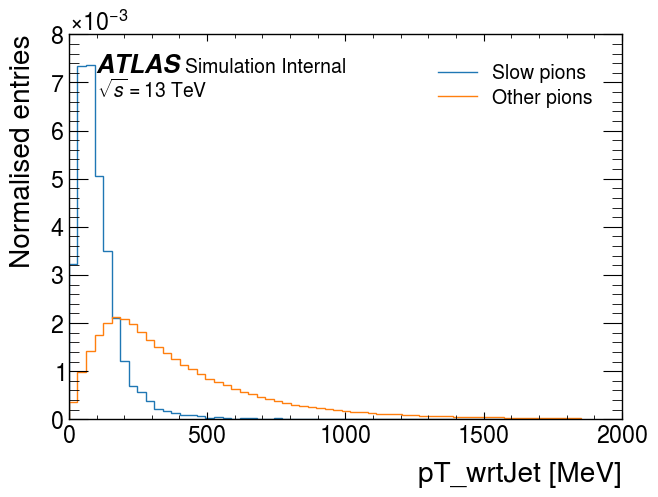

In [11]:
tidy_df = df.replace([np.inf, -np.inf], np.nan)
tidy_df.dropna(subset=["pT_wrtJet", "truthSlowPion"], how="all", inplace=True)
df_slowpion = tidy_df[(tidy_df["truthSlowPion"] == True)]
df_otherpions = tidy_df[(tidy_df["truthSlowPion"] == False)]

hep.style.use(hep.style.ATLAS)

f, ax = plt.subplots(figsize=(7, 5))
hsig, bins = np.histogram(df_slowpion["pT_wrtJet"], bins=60, density=1)
hbkg, bins = np.histogram(df_otherpions["pT_wrtJet"], bins=bins, density=1)
hep.histplot((hsig, bins), label='Slow pions', ax=ax)
hep.histplot(hbkg, bins=bins, label='Other pions', ax=ax)
plt.xlabel('pT_wrtJet [MeV]')
plt.ylabel('Normalised entries')
hep.atlas.label(loc=4, label="Internal", ax=ax)
plt.legend(loc='best')
f.savefig('plot_pT_wrtJet_mplhep.png')

### Exploratory data analysis

**Tasks:**

- find out which other variables besides the transverse momentum with respect to the jet axis provide good discrimination between slow pions and pions from other sources than the charged D hadron decay
- look at the impact parameters (`IP3D_signed_d0`, `IP3D_signed_z0`) of the slow pions which originate from D* mesons produced directly in the proton collisions and at the impact parameters of those which are produced by as part of the cascade decay of a b-hadron. How is it possible to distinguish jets with b-hadrons from jets with c-hadrons using the slow pions in the D* decay?

**Note:** The transverse impact parameter, **d0**, is defined as the distance of closest approach of the track to the primary vertex point, in the r−φ projection. The tracks from b-hadron decay products tend to have rather large d0, which let us distinguish them from the ones stemming from the primary vertex. Similarly, **z0** is the longitudinal impact parameters.